# Image Processing - SCC0251

### Final Project - Oculus Extinguisher
SCC5830: Image processing, first semester of 2020 at University of São Paulo (USP)
Professor: Moacir A. Ponti

 Authors:
* Amanda Carrijo Viana Figur (N. USP: 8937736)

* Luiz Augusto Vieira Manoel (N. USP: 8937308)


**Abstract:**

The aim of this project is to "erase" the eyeglasses of photos by filling removed pixels from people's faces. This technique is known as Inpainting and we made it by using Color Processing, Histogram Analysis, Image Enhancement, Morphology and Segmentation. Our project receives a RGB image of a person's face wearing eyeglasses, extracts the eyeglasses mask and returns the respective inpaited image without the eyeglasses. We used Python 3 to make all our codes and Adobe Photoshop to obtain some of our images. This process might help with facial recognition problems.

**Keywords:** Inpainting; Faces; Mask; Extraction; Segmentation.


## Introductory tools

First we are going to import some libraries and implement some functions we'll need to obtain our results.

The `plot_compare` function receives two images, `m` being the modified image and `r`being the reference image, and plots the two images side by side using `matplotlib.pyplot`.

The `RMSE` function computes the error between a reference image `r` and a modified image `m` using `numpy` to alculate the root-mean-square error.

In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import sys
from math import sqrt as sqrt
from skimage import morphology as morp
import heapq

def plot_compare(r, m):
    plt.figure(figsize=(12, 12))

    # defines a panel to show the images side by side
    plt.subplot(121)  # panel with 1 row, 2 columns, to show the image at the first (1st) position
    plt.imshow(r, cmap="gray")
    plt.axis('off')  # remove axis with numbers

    plt.subplot(122)  # panel with 1 row, 2 columns, to show the image at the second (2nd) position
    plt.imshow(m, cmap="gray")
    plt.axis('off')

    plt.show()

def RMSE(r, m):
    # converts values to float
    m = m.astype(np.float32)
    r = r.astype(np.float32)

    #calculates how many pixels image has
    N, M = r[:,:,0].shape
    T = N*M

    # auxiliary matrix for computations
    aux = np.subtract(m,r)
    aux = np.power(aux, 2)
    mean = np.divide(np.sum(aux),T)
    RMSE = np.sqrt(mean)

    # prits error with 4 decimal places and adjusts identation
    print(f"{RMSE:.4f}\n", sep='', end='')

# Building Inpainting Algorithms

We obtained a Fidel Castro image and, using Photoshop, artificialy added (by drawing) eyeglasses on his face.

This altered image is going to work as a reference for our inpainting algorithms. We used the `RMSE` function to calculate the difference between the original image and the inpainted outputs we obtained. We also used Photoshop to build a mask to use at the inpainting algorithms.

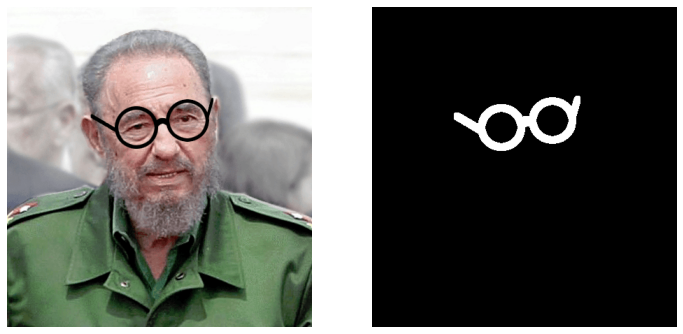

In [ ]:
original_img = imageio.imread('./images/original_Fidel.png')
img = imageio.imread('./images/oculus_Fidel.png')
mask = imageio.imread('./images/manual_mask_Fidel.png')
plot_compare(img, mask)

We used three different inpainting algorithms: PyHeal, Popular Inpainting and Revolution Inpainting, wich we are going to describe bellow.

## PyHeal Inpainting

This Image Inpainting Technique Based on the **Fast Marching Method** (FMM). The idea behind such method is to replace the eyeglasses estimating the image smoothness as a weighted average over a known neighborhood of the pixel to inpaint.

The algorithm will be implemented in `Python 3`. We used as main reference the <a title="Code" href="https://github.com/olvb/pyheal" target="_blank" rel="noopener">PyHeal</a> code, a pure Python implementation of Telea article on FMM inpainting. Such article can be found <a title="Article" href="https://www.researchgate.net/publication/238183352_An_Image_Inpainting_Technique_Based_on_the_Fast_Marching_Method" target="_blank" rel="noopener">here</a>: "An Image Inpainting Technique Based on the Fast Marching Method", by Alexandru Telea at the Eindhoven University of Technology, DOI: 10.1080/10867651.2004.10487596.

This function was our first attempt to implement an inpainting algorithm. Most of the inpainting algorithms in literature are very sofisticated and this was the only algorithm fully implemented using basic Python Libraries we found. 

Through this algoritm implementation we could better understand how an inpainting algorithm works.

In [ ]:
# flags
KNOWN = 0
BAND = 1
UNKNOWN = 2
# extremity values
INF = 1e6 # dont use np.inf to avoid inf * 0
EPS = 1e-6

# solves a step of the eikonal equation in order to find closest quadrant
def _solve_eikonal(y1, x1, y2, x2, height, width, dists, flags):
    # check image frame
    if y1 < 0 or y1 >= height or x1 < 0 or x1 >= width:
        return INF

    if y2 < 0 or y2 >= height or x2 < 0 or x2 >= width:
        return INF

    flag1 = flags[y1, x1]
    flag2 = flags[y2, x2]

    # both pixels are known
    if flag1 == KNOWN and flag2 == KNOWN:
        dist1 = dists[y1, x1]
        dist2 = dists[y2, x2]
        d = 2.0 - (dist1 - dist2) ** 2
        if d > 0.0:
            r = sqrt(d)
            s = (dist1 + dist2 - r) / 2.0
            if s >= dist1 and s >= dist2:
                return s
            s += r
            if s >= dist1 and s >= dist2:
                return s
            # unsolvable
            return INF

    # only 1st pixel is known
    if flag1 == KNOWN:
        dist1 = dists[y1, x1]
        return 1.0 + dist1

    # only 2d pixel is known
    if flag2 == KNOWN:
        dist2 = dists[y2, x2]
        return 1.0 + dist2

    # no pixel is known
    return INF

# returns gradient for one pixel, computed on 2 pixel range if possible
def _pixel_gradient(y, x, height, width, vals, flags):
    val = vals[y, x]

    # compute grad_y
    prev_y = y - 1
    next_y = y + 1
    if prev_y < 0 or next_y >= height:
        grad_y = INF
    else:
        flag_prev_y = flags[prev_y, x]
        flag_next_y = flags[next_y, x]

        if flag_prev_y != UNKNOWN and flag_next_y != UNKNOWN:
            grad_y = (vals[next_y, x] - vals[prev_y, x]) / 2.0
        elif flag_prev_y != UNKNOWN:
            grad_y = val - vals[prev_y, x]
        elif flag_next_y != UNKNOWN:
            grad_y = vals[next_y, x] - val
        else:
            grad_y = 0.0

    # compute grad_x
    prev_x = x - 1
    next_x = x + 1
    if prev_x < 0 or next_x >= width:
        grad_x = INF
    else:
        flag_prev_x = flags[y, prev_x]
        flag_next_x = flags[y, next_x]

        if flag_prev_x != UNKNOWN and flag_next_x != UNKNOWN:
            grad_x = (vals[y, next_x] - vals[y, prev_x]) / 2.0
        elif flag_prev_x != UNKNOWN:
            grad_x = val - vals[y, prev_x]
        elif flag_next_x != UNKNOWN:
            grad_x = vals[y, next_x] - val
        else:
            grad_x = 0.0

    return grad_y, grad_x

# compute distances between initial mask contour and pixels outside mask, using FMM (Fast Marching Method)
def _compute_outside_dists(height, width, dists, flags, band, radius):
    band = band.copy()
    orig_flags = flags
    flags = orig_flags.copy()
    # swap INSIDE / OUTSIDE
    flags[orig_flags == KNOWN] = UNKNOWN
    flags[orig_flags == UNKNOWN] = KNOWN

    least_dist = 0.0
    while band:
        # reached radius limit, stop FMM
        if least_dist >= radius * 2:
            break

        # pop BAND pixel closest to initial mask contour and flag it as KNOWN
        _, x, y = heapq.heappop(band)
        flags[x, y] = KNOWN

        # process immediate neighbors (top/bottom/left/right)
        neighbors = [(x - 1, y), (x, y - 1), (x + 1, y), (x, y + 1)]
        for x_nb, y_nb in neighbors:
            # skip out of frame
            if x_nb < 0 or x_nb >= height or y_nb < 0 or y_nb >= width:
                continue

            # neighbor already processed, nothing to do
            # search for no-eyeglasses pixels 
            if flags[x_nb, y_nb] != UNKNOWN:
                continue

            # compute neighbor distance to inital mask contour
            least_dist = min([
                _solve_eikonal(x_nb - 1, y_nb, x_nb, y_nb - 1, height, width, dists, flags),
                _solve_eikonal(x_nb + 1, y_nb, x_nb, y_nb + 1, height, width, dists, flags),
                _solve_eikonal(x_nb - 1, y_nb, x_nb, y_nb + 1, height, width, dists, flags),
                _solve_eikonal(x_nb + 1, y_nb, x_nb, y_nb - 1, height, width, dists, flags)
            ])
            dists[x_nb, y_nb] = least_dist

            # add neighbor to narrow band
            flags[x_nb, y_nb] = BAND
            heapq.heappush(band, (least_dist, x_nb, y_nb))

    # distances are opposite to actual FMM propagation direction, fix it
    dists *= -1.0

# computes pixels distances to initial mask contour, flags, and narrow band queue
def _init(height, width, mask, radius):
    # init all distances to infinity
    dists = np.full((height, width), INF, dtype=float)
    # sets the eyeglasses pixels as UNKNOWN and black region of mask as KNOWN
    flags = mask.astype(int) * UNKNOWN
    # narrow band, queue of contour pixels
    band = []

    # get all indices of pixels that represents the eyeglasses on mask 
    x_mask, y_mask = mask.nonzero()
    
    # set the KWON neighbors pixels as BAND and its distance from UNKNOWN pixels as 0
    for x, y in zip(x_mask, y_mask):
        # look for BAND pixels in neighbors (top/bottom/left/right)
        neighbors = [(x - 1, y), (x, y - 1), (x + 1, y), (x, y + 1)]
        for x_nb, y_nb in neighbors:
            # neighbor out of frame
            if x_nb < 0 or x_nb >= height or y_nb < 0 or y_nb >= width:
                continue

            # neighbor already flagged as BAND
            if flags[x_nb, y_nb] == BAND:
                continue

            # neighbor out of mask => mask contour
            if mask[x_nb, y_nb] == 0:
                flags[x_nb, y_nb] = BAND
                dists[x_nb, y_nb] = 0.0
                heapq.heappush(band, (0.0, x_nb, y_nb))


    # compute distance to inital mask contour for KNOWN pixels (black region)
    # (by inverting mask/flags and running FMM)
    _compute_outside_dists(height, width, dists, flags, band, radius)

    return dists, flags, band

# returns RGB values for pixel to by inpainted, computed for its neighborhood
def _inpaint_pixel(y, x, img, height, width, dists, flags, radius):
    dist = dists[y, x]
    # normal to pixel, ie direction of propagation of the FMM
    dist_grad_y, dist_grad_x = _pixel_gradient(y, x, height, width, dists, flags)
    pixel_sum = np.zeros((3), dtype=float)
    weight_sum = 0.0

    # iterate on each pixel in neighborhood (nb stands for neighbor)
    for nb_y in range(y - radius, y + radius + 1):
        #  pixel out of frame
        if nb_y < 0 or nb_y >= height:
            continue

        for nb_x in range(x - radius, x + radius + 1):
            # pixel out of frame
            if nb_x < 0 or nb_x >= width:
                continue

            # skip unknown pixels (including pixel being inpainted)
            if flags[nb_y, nb_x] == UNKNOWN:
                continue

            # vector from point to neighbor
            dir_y = y - nb_y
            dir_x = x - nb_x
            dir_length_square = dir_y ** 2 + dir_x ** 2
            dir_length = sqrt(dir_length_square)
            # pixel out of neighborhood
            if dir_length > radius:
                continue

            # compute weight
            # neighbor has same direction gradient => contributes more
            dir_factor = abs(dir_y * dist_grad_y + dir_x * dist_grad_x)
            if dir_factor == 0.0:
                dir_factor = EPS

            # neighbor has same contour distance => contributes more
            nb_dist = dists[nb_y, nb_x]
            level_factor = 1.0 / (1.0 + abs(nb_dist - dist))

            # neighbor is distant => contributes less
            dist_factor = 1.0 / (dir_length * dir_length_square)

            weight = abs(dir_factor * dist_factor * level_factor)

            pixel_sum[0] += weight * img[nb_y, nb_x, 0]
            pixel_sum[1] += weight * img[nb_y, nb_x, 1]
            pixel_sum[2] += weight * img[nb_y, nb_x, 2]

            weight_sum += weight

    return pixel_sum / weight_sum

# main inpainting function
def inpanting_pyheal(original_img, mask, radius=5):

    #set all black pixels to 0 and white pixels to 1
    mask = mask[:, :, 0].astype(bool, copy=False)

    img = original_img.copy()

    height, width = img.shape[0:2]
    dists, flags, band = _init(height, width, mask, radius)

    # find next pixel to inpaint with FMM (Fast Marching Method)
    # FMM advances the band of the mask towards its center,
    # by sorting the area pixels by their distance to the initial contour
    while band:
        # pop band pixel
        # get all indices of pixels that represents the eyeglasses on mask closest to initial mask contour
        _, x, y = heapq.heappop(band)
        # flag it as KNOWN
        flags[x, y] = KNOWN

        # process his immediate neighbors (top/bottom/left/right)
        neighbors = [(x - 1, y), (x, y - 1), (x + 1, y), (x, y + 1)]
        for x_nb, y_nb in neighbors:
            # pixel out of frame
            if x_nb < 0 or x_nb >= height or y_nb < 0 or y_nb >= width:
                continue

            # neighbor outside of initial mask or already processed, nothing to do
            if flags[x_nb, y_nb] != UNKNOWN:
                continue

            # compute neighbor distance to inital mask contour
            nb_dist = min([
                _solve_eikonal(x_nb - 1, y_nb, x_nb, y_nb - 1, height, width, dists, flags),
                _solve_eikonal(x_nb + 1, y_nb, x_nb, y_nb + 1, height, width, dists, flags),
                _solve_eikonal(x_nb - 1, y_nb, x_nb, y_nb + 1, height, width, dists, flags),
                _solve_eikonal(x_nb + 1, y_nb, x_nb, y_nb - 1, height, width, dists, flags)
            ])
            dists[x_nb, y_nb] = nb_dist

            # inpaint neighbor
            pixel_vals = _inpaint_pixel(x_nb, y_nb, img, height, width, dists, flags, radius)

            img[x_nb, y_nb, 0] = pixel_vals[0]
            img[x_nb, y_nb, 1] = pixel_vals[1]
            img[x_nb, y_nb, 2] = pixel_vals[2]

            # add neighbor to narrow band
            flags[x_nb, y_nb] = BAND
            # push neighbor on band
            heapq.heappush(band, (nb_dist, x_nb, y_nb))

    return img

Below we can see the PyHeal algorithm being implemented.

We compare side by side:


1.   Fidel wearing eyeglasses and the inpainted output by PyHeal
2.   The inpainted outout by PyHeal and the original Fidel image

We also show the resulting `RMSE` from our second comparison 



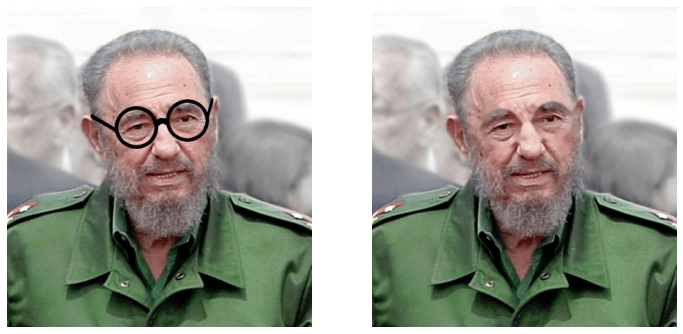

RMSE Original - Pyheal(manual mask)
8.9814


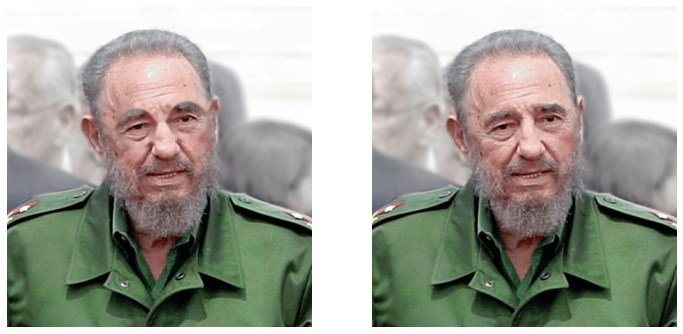

In [ ]:
img_pyheal = inpanting_pyheal(img, mask, 4)
plot_compare(img, img_pyheal)
print('RMSE Original - Pyheal(manual mask)')
RMSE(original_img, img_pyheal)
plot_compare(img_pyheal, original_img)

Althought PyHeal is a simple algorithm in research area, it's not as  simple as an inpainting algorithm can be. The next algorithm we implemented uses only the core requierements in order to an inpainting algorithm exist. We implemented this algorithm after Moacir's help.

## Popular Inpainting

This algorithm receives an `input_img` and a `mask`. Then it proceeds to find on the `input_img` the white pixels on the `mask`. Once it finds a pixel that is going to be inpainted, it starts to generate subregions of size `k` around this pixel. It replaces the pixel that is going to be inpainted by the first pixel it finds on the subregion that's on the black region of the mask. The value of `k` increases while the algorithm can't find such pixel.



In [ ]:
def inpainting_popular(input_img, mask):

	# TODO normalizar as imagens
	N, M = input_img.shape[0:2]
	r = input_img.copy()
	for i in range(0, N):
		for j in range(0, M):
			if mask[i,j,0] == 255:
				inpainting_search_popular(r, mask, i, j)

	return r

def inpainting_search_popular(input_img, mask, i, j):

	k = 2
	inpainted = False

	while(not inpainted):

		sub_region_base = morp.disk(k)
	
		sub_region_input = input_img[i - k: i + k + 1, j - k:j + k + 1]
		sub_region_mask = mask[i - k: i + k + 1, j - k:j + k + 1]

		for x in range(0, ((2*k) +1)):
			for y in range(0, ((2*k) +1)):
				if sub_region_base[x,y] == 1 and sub_region_mask[x,y,0] == 0:
					input_img[i,j,:] = sub_region_input[x,y,:]
					inpainted = True

		k += 1

Below we can see the Popular Inpainting algorithm being implemented.

We compare side by side:


1.   Fidel wearing eyeglasses and the inpainted output by Popular Inpainting
2.   The inpainted outout by Popular Inpainting and the original Fidel image

We also show the resulting `RMSE` from our second comparison 

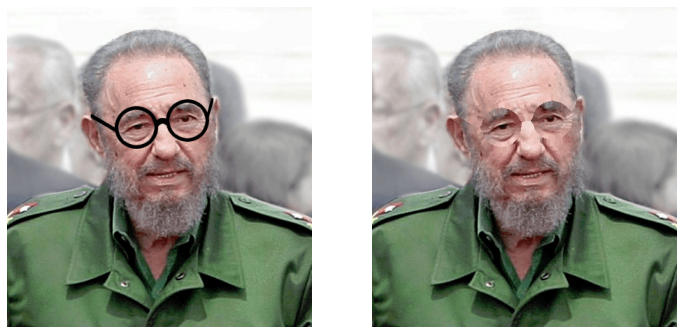

RMSE Original - Popular(manual mask)
9.8786


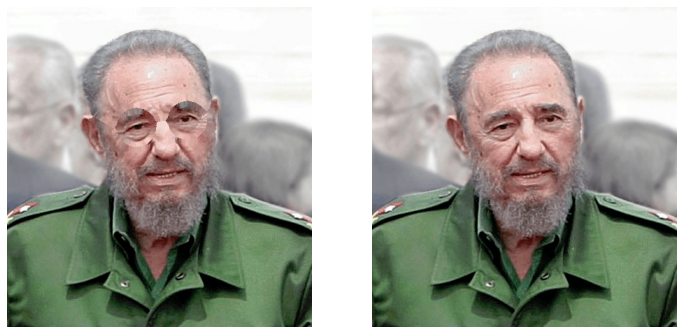

In [ ]:
img_popular = inpainting_popular(img, mask)
plot_compare(img, img_popular)
print('RMSE Original - Popular(manual mask)')
RMSE(original_img, img_popular)
plot_compare(img_popular, original_img)

Althought Popular inpainting is a very simple algorith and the output is satisfactory, it doesn't count with an image descriptor (a way to decide wich pixel is adequate to substitute the pixel that's going to be inpainted). The following algorithm implements an image descriptor method.

## Revolution Inpainting

This algorithm works based on the previous Popular Inpainting implemented. It still creates a subregion around a region that's going to be inpainted. Then it searches for the nearest pixel to the pixel that's going to be inpaited using the Euclidian Distance. After that, it creates a subregion of size 3 x 3 around this nearest pixel. Then it calculates the mean value for each RGB channel of the pixels inside the 3 x 3 subregion and outside of the white part of the mask. In the end, each channel of the pixel that's going to be inpainted receives it's respective mean calculated value.

In [ ]:
NF = 10000000000

def inpainting_revolution(input_img, mask):

	# TODO normalizar as imagens
	N, M = input_img.shape[0:2]
	r = input_img.copy()
	for i in range(0, N):
		for j in range(0, M):
			if mask[i,j,0] == 255:
				inpainting_search_revolution(r, mask, i, j)

	return r

def euclidian_distance(i, j, x, y):
	return np.sqrt(((x - i) * (x - i)) + ((y - j) * (y - j)))

def inpainting_search_revolution(input_img, mask, i, j):

	k = 2
	inpainted = False

	min_distance = INF
	min_distance_x = 0
	min_distance_y = 0

	while(not inpainted):

		sub_region_base = morp.disk(k)
	
		sub_region_input = input_img[i - k: i + k + 1, j - k:j + k + 1]
		sub_region_mask = mask[i - k: i + k + 1, j - k:j + k + 1]

		for x in range(0, ((2*k) +1)):
			for y in range(0, ((2*k) +1)):
				if sub_region_base[x,y] == 1 and sub_region_mask[x,y,0] == 0:
					euc_distance = euclidian_distance(i, j, x, y)
					if euc_distance < min_distance:
						min_distance = euc_distance
						min_distance_x = x
						min_distance_y = y	 

		if min_distance < INF:
			n_pixels = 0
			sum_pixelsR = 0
			sum_pixelsG = 0
			sum_pixelsB = 0
			for z in range(min_distance_x - 1, min_distance_x + 2):
				for w in range(min_distance_y -1, min_distance_y + 2):
					if z >= 0 and z <= 2*k and w >=0 and w <= 2*k:
						if sub_region_base[z,w] == 1 and sub_region_mask[z,w,0] == 0:
							sum_pixelsR += sub_region_input[z,w,0]
							sum_pixelsG += sub_region_input[z,w,1]
							sum_pixelsB += sub_region_input[z,w,2]
							n_pixels += 1	

			mean_pixels_valueR = sum_pixelsR / n_pixels
			mean_pixels_valueG = sum_pixelsG / n_pixels
			mean_pixels_valueB = sum_pixelsB / n_pixels
			input_img[i,j,0] = mean_pixels_valueR
			input_img[i,j,1] = mean_pixels_valueG
			input_img[i,j,2] = mean_pixels_valueB
			inpainted = True

		k += 1

Below we can see the Revolution Inpainting algorithm being implemented.

We compare side by side:


1.   Fidel wearing eyeglasses and the inpainted output by Revolution Inpainting
2.   The inpainted outout by Revolution Inpainting and the original Fidel image

We also show the resulting `RMSE` from our second comparison 

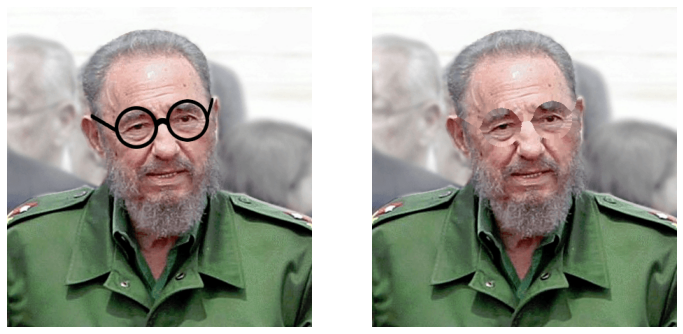

RMSE Original - Revolution(manual mask)
9.7663


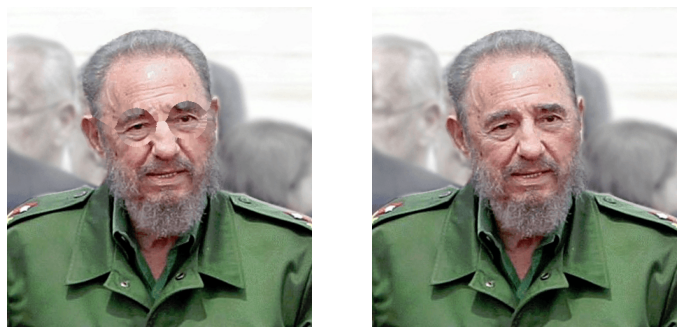

In [ ]:
img_revolution = inpainting_revolution(img, mask)
plot_compare(img, img_revolution)
print('RMSE Original - Revolution(manual mask)')
RMSE(original_img, img_revolution)
plot_compare(img_revolution, original_img)

### Comparing Inpainting algorithms results

We can compare the results obtained by the three algoritms and rank them acordingly to it's `RMSE`results. A lower `RMSE` value means it's closer to the original Fidel's image, and we say it means a better inpainting.

| Rank | Algorithm | RMSE result |
|:--:|:--:|:--:|
|1| PyHeal (manual mask) | 8.9814 |
|2| Revolution (manual mask) | 9.7663 |
|3| Popular (manual mask) | 9.8786 |


---


The mask we used as input was obtained manually. Since the inpainting algorithms depend on an input mask, we decided to implement an algorithm that generates such mask from the image that's going to be inpainted.

Now we are going to show the algorithm that obtain suck mask and after that implement the sabe three algorithms for the generated mask.

# Generating a mask

Our mask generator has a main function called `mask_generator`, wich receives as input only the `filename` of the image we are going to generate the mask and a `seed` with the coordinates of a single pixel that's inside the eyeglasses on the original image.

We are going to detail each step of this function later, but we implemented a lot of other functions in order to be able to generate the mask. We'll show them now.

The functions below implement image enhancement techniques.

We implemented a `brightness`function wich has it's output values normalized by a `brightness_normalization` function.

We implemented a `contrast` and `inversion` function and also a `image_normalization` function for the later operations.

In [ ]:
# Normalizes an image r (turns max intensity to 255 and min intensity to 0)
def image_normalization(r):
    a = np.amin(r)  # least intensity
    b = np.amax(r)  # maximum intensity
    # normalizer
    r = np.divide((r - a),(b - a))*255
    return r.astype(np.uint8)

# Brightness modulation by a value c in range 0-255
def brightness(input_img, c):
    input_img_copy = input_img.copy().astype(np.float32)
    input_img_copy = input_img_copy + c
    input_img_copy = brightness_normalization(input_img_copy)
    return input_img_copy.astype(np.uint8)

# Normalizes the increased or decreased brightness of an image
def brightness_normalization(input_img):
    N, M = input_img.shape
    for i in range(0, N):
        for j in range(0, M):
            if (input_img[i, j] < 0): #sets values below zero to zero
                input_img[i, j] = 0
            elif (input_img[i, j] > 255): #sets values above 255 to 255
                input_img[i, j] = 255

    return input_img

# Constrat modulation: c is the lowest value and d is the highest value
def contrast(input_img, c, d):
    a = np.amin(input_img)
    b = np.amax(input_img)
    return (((input_img.astype(np.float32) - a) * (d - c) / (b - a)) + c).astype(np.uint8)

# Inverts values of an image
def inversion(input_img):
    return (255 - input_img.astype(np.float32)).astype(np.uint8)

We also implemented two morphology functions that will oparate the `opening` and `closing` operations on a grayscale image.

In [ ]:
# performs the opening operation on a grayscale image
def opening(input_img, k):
    structuring_element = morp.disk(k)
    img1 = morp.opening(input_img, structuring_element)
    return img1

# performs the closing operation on a grayscale image
def closing(input_img, k):
    structuring_element = morp.disk(k)
    img1 = morp.closing(input_img, structuring_element)
    return img1

We also used a image segmentation technique to extract the eyeglasses from the image.

This `region_growing_average` function receives an `img` that's going to be segmented and a `seed` to start the growing of the region. Starting from the `seed`, it will write in white on the `img_t` a connected region with values bellow the given `tolerance`.

In [ ]:
sys.setrecursionlimit(1000000)  #allow 'region_growing_average' algorithm to run

#grows a binary image begining from a seed
def region_growing_average(img, img_t, tolerance, seed):
    x = seed[0]
    y = seed[1]

    img_t[x, y] = 1

    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y + 1 < img.shape[1] and img_t[x, y + 1] == 0 and img[x, y + 1] <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y + 1])

    if (y - 1 >= 0 and img_t[x, y - 1] == 0 and img[x, y - 1] <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y - 1])

    if (x + 1 < img.shape[0] and img_t[x + 1, y] == 0 and img[x + 1, y] <= tolerance):
        region_growing_average(img, img_t, tolerance, [x + 1, y])

    if (x - 1 >= 0 and img_t[x - 1, y] == 0 and img[x - 1, y] <= tolerance):
        region_growing_average(img, img_t, tolerance, [x - 1, y])

We also perform a binarization of an `input_img` image using the `threshold_binarization` function. This function sets all the `input_img` values below a given `threshold` to zero (turn them into black pixels) and all values equal or above the `threshold` to 255 (turn them into white pixels).

This threshold is determined by the `define_threshold` function, wich sets a small subregion around a given seed and generates the `histogram` of this subregion. Then this function finds the smallest value on this histogram and find the most frequent midtone value. The most frequent midtone value is our threshold.

In [ ]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A == i)
        
        #print(pixels_value_i)  # uncomment to print array of coordinates
        
        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

def define_threshold(input_img, seed):
    x = seed[0]
    y = seed[1]
    oculus_region = input_img[x - 5: x + 5, y - 5: y + 5]
    #plot_compare(input_img,oculus_region)

    hist = histogram(oculus_region, 256)
    
    min_i = -1
    for i in range(0, len(hist)):
        if hist[i] != 0:
            min_i = i
            break

    mean_i = (256 - min_i) // 2

    max_hist = 0
    max_i = -1
    for i in range(min_i + mean_i, 200):
        if hist[i] > max_hist:
            max_hist = hist[i]
            max_i = i


    return max_i - 1

# binarizes a gray image by a threshold t in range 0-255.
def treshold_binarization(input_img, t):
    N, M = input_img.shape
    r = input_img.copy()
    for i in range(0, N):
        for j in range(0, M):  #Values equal or greater to threshhold t are white
            if (r[i, j] >= t):
                r[i, j] = 255
            else:              #Values below the threshhold t are black
                r[i, j] = 0
    return r

Now we can finally show the `mask_generator` function and explain each step we perform on and input image to obtain its mask.



1.   First we want only the representation of light from the image, so we turn it to grayscale
2.   We want only the eyeglasses, so we made the image brighter so the midtones from skin turn into white
3. But we still want the darker tones, so we also make a contrast adjustmento to the image
4. We make an opening on the grayscale image, so only our lighter tones become more uniform
5. After the opening, we try to find an adequate threshold to perform the binarization of the image
6. We also want to dilate the darker areas (that contain the eyeglasses), so we invert the image values, perform the dilation, then do another inversion to obtain our binary image with the desired dilation
7. Then, from a seedpoint, we run our segmentation algorithm and after that we normalize the values, so black regions have value 0 and white regions have value 255
8. We end the process returnin a mask on its RGB form, so our other algorithms can work with it



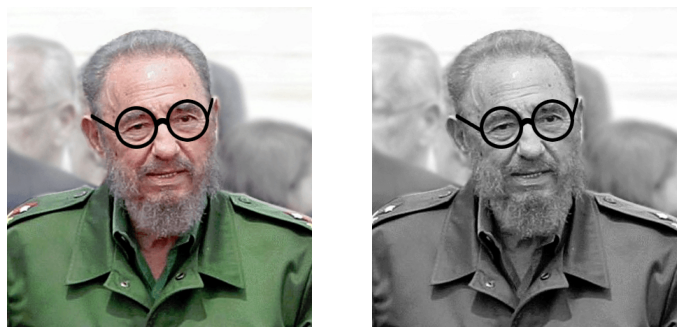

We'll need only values (not color) information to build the mask.


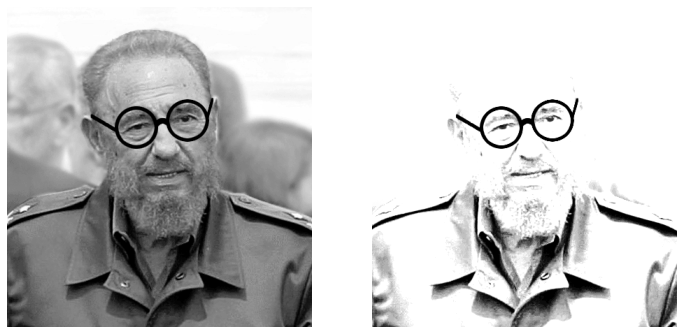

Brighter image


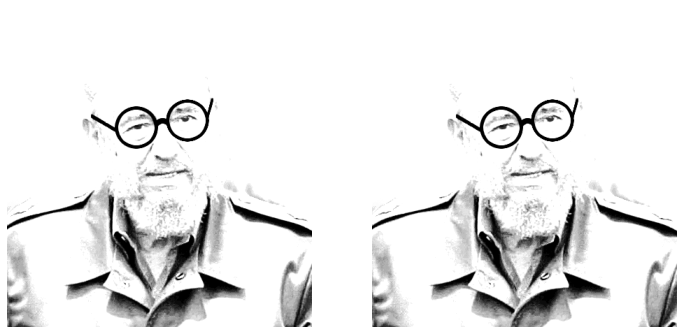

After the constrat modulation


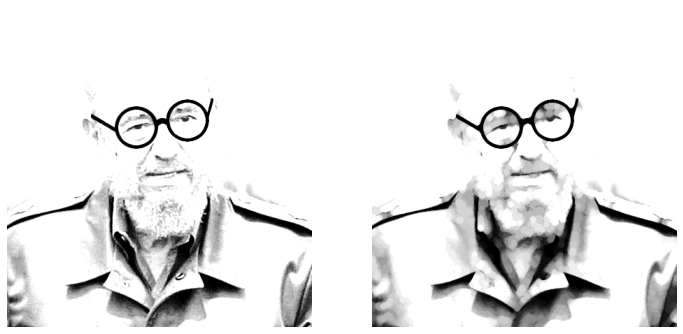

After performing an opening of radius 4


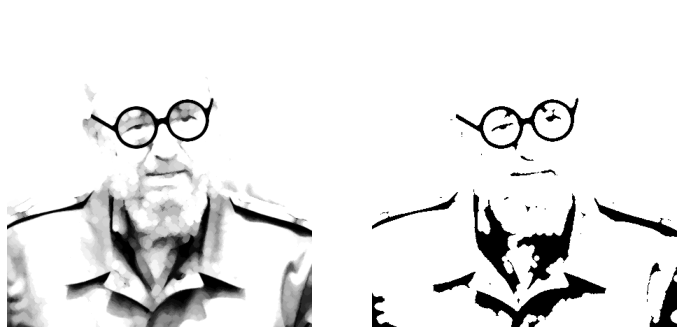

After binarization


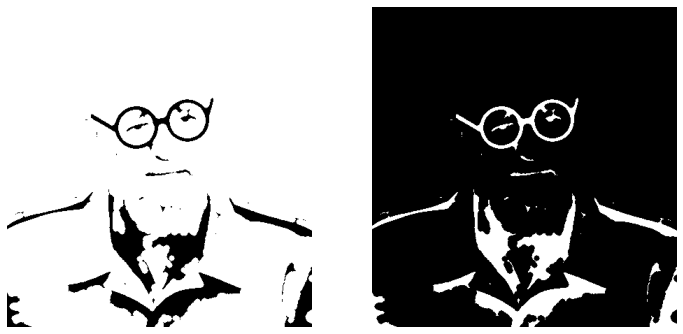

After inversion


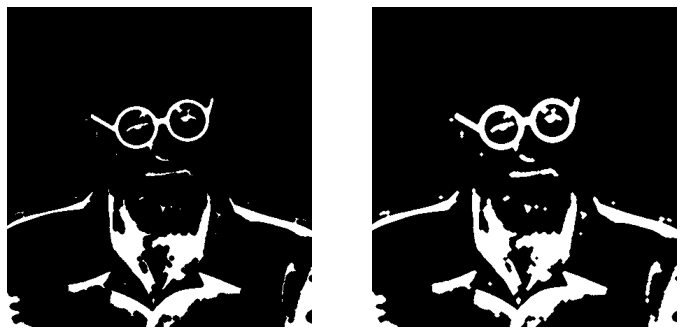

After dilation


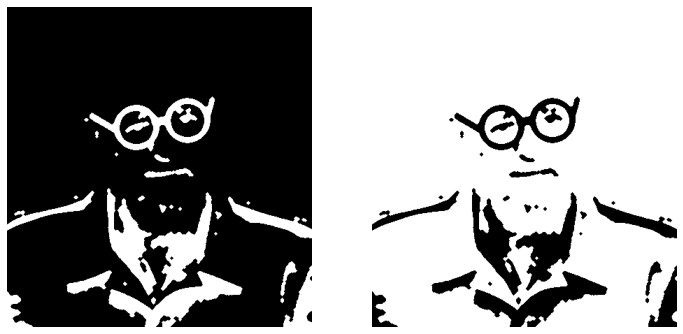

After re-inversion


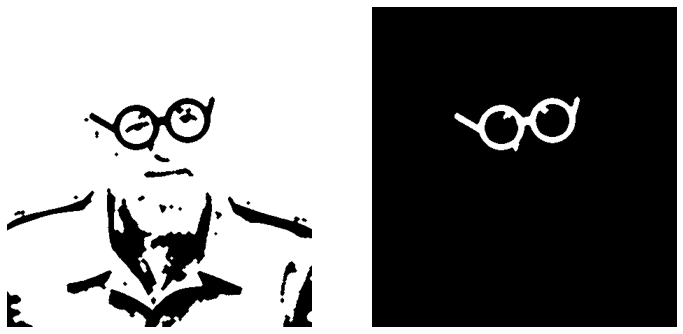

After region growing algorithm


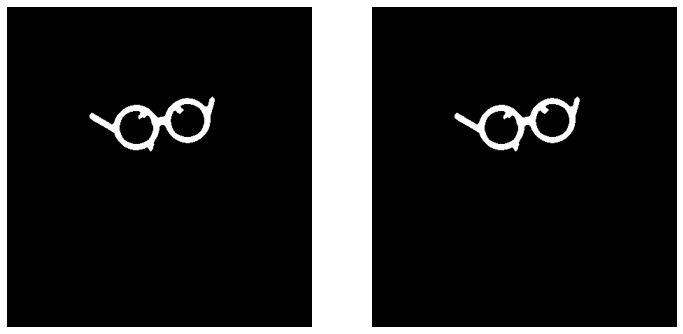

After normalization


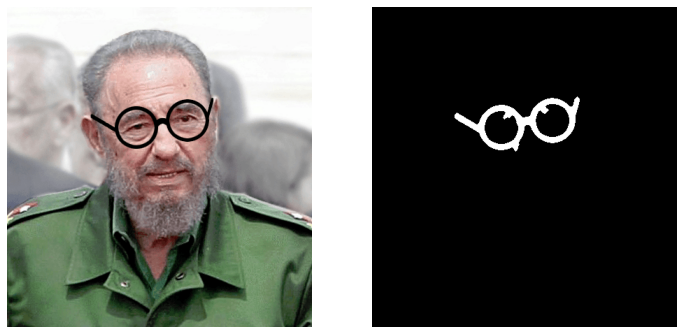

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                    THE MASK GENERATION FUNCTION                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def mask_generator(filename, seed):
    # Starts program with an RGB image and converts it to grayscale
    original_image = imageio.imread(filename)
    grayscale_image = 0.2125 * original_image[:,:,0] + 0.7154 * original_image[:,:,1] + 0.0721 * original_image[:,:,2]
    plot_compare(original_image, grayscale_image)
    print("We'll need only values (not color) information to build the mask.")
    '''
        smoothening image, so it has less noise. Also the objective is to increase
        the contrast between the skin and the eyeglasses, so we can find the eyeglasses
        easily.
    '''
    brighter_img = brightness(grayscale_image,150) #144
    plot_compare(grayscale_image,brighter_img)
    print("Brighter image")
    contrast_img = contrast(brighter_img,0,255)
    plot_compare(brighter_img,contrast_img)
    print("After the constrat modulation")
    open_img = opening(contrast_img,4) #disk of radius 4 for opening
    plot_compare(contrast_img,open_img)
    print("After performing an opening of radius 4")

    #making operations on binary img
    binary_img = treshold_binarization(open_img,define_threshold(open_img,seed))
    plot_compare(open_img,binary_img)
    print("After binarization")

    # we have some operations that can only be perfomed on the white area of the image
    invert_img = inversion(binary_img)
    plot_compare(binary_img, invert_img)
    print("After inversion")
    
    disk = morp.disk(2)
    dilated_img = morp.dilation(invert_img, disk)
    plot_compare(invert_img, dilated_img)
    print("After dilation")

    #the binary image again, with operations applyed
    binary_img = inversion(dilated_img)
    plot_compare(dilated_img, binary_img)
    print("After re-inversion")


    '''
        Now we are going to perform the image segmentation at the binary image. We need seeds
        and the final output should be the wanted eyeglasses mask.
    '''
    img_seed = np.zeros(grayscale_image.shape)  #the segmentations are saved here
    #performs search using two seeds
    region_growing_average(binary_img, img_seed, 0, seed)
    #region_growing_average(binary_img, img_seed, 0, [282, 202])
    #plots images
    plot_compare(binary_img, img_seed)
    print("After region growing algorithm")

    #normalizes the seed, so it has Grayscale values
    grayscale_mask = image_normalization(img_seed)
    plot_compare(img_seed, grayscale_mask)
    print("After normalization")

    #Composing a RGB image
    rgb_mask = np.zeros(original_image.shape, dtype=np.uint8)
    rgb_mask[:,:,0] = grayscale_mask
    rgb_mask[:,:,1] = grayscale_mask
    rgb_mask[:,:,2] = grayscale_mask

    # plot_compare(original_image, rgb_mask)
    # img.imwrite(filename + 'generated-mask.png', rgb_mask.astype(np.uint8))

    return rgb_mask

mask2 = mask_generator('./images/oculus_Fidel.png', [164, 228])
plot_compare(img, mask2)

# Inpainting with the generated mask

We now are going to present the same algorithms implemented to the generated mask.

## PyHeal Inpainting

It's the same algorithm we presented above, but now using the generated mask.

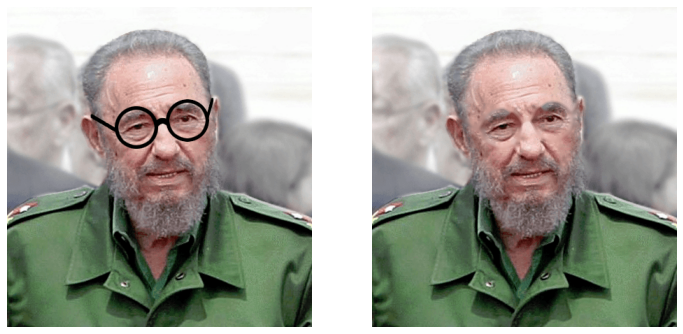

RMSE Original - PyHeal(generated mask)
7.5761


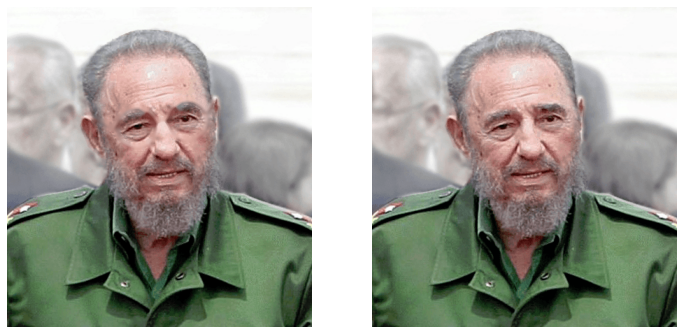

In [ ]:
img_pyheal = inpanting_pyheal(img, mask2, 4)
plot_compare(img, img_pyheal)
print('RMSE Original - PyHeal(generated mask)')
RMSE(original_img, img_pyheal)
plot_compare(img_pyheal, original_img)

## Popular Inpainting

It's the same algorithm we presented above, but now using the generated mask.


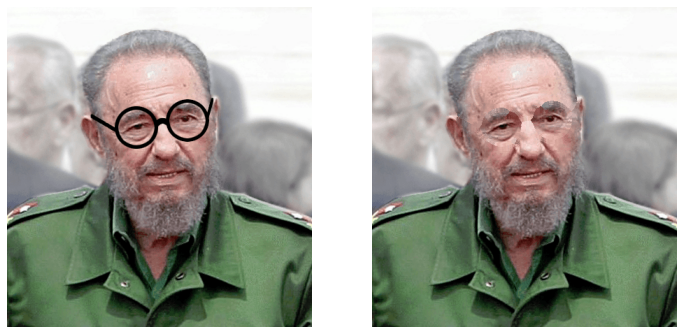

RMSE Original - Popular(generated mask)
8.2365


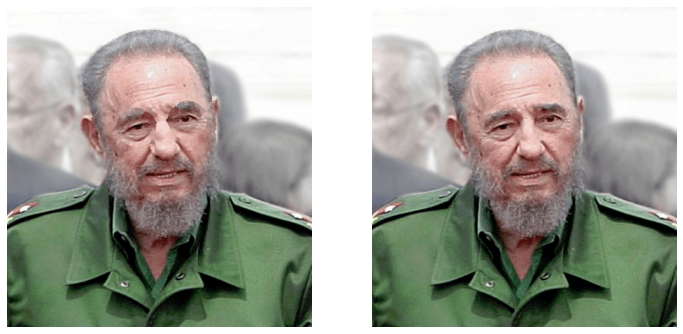

In [ ]:
img_popular = inpainting_popular(img, mask2)
plot_compare(img, img_popular)
print('RMSE Original - Popular(generated mask)')
RMSE(original_img, img_popular)
plot_compare(img_popular, original_img)

## Popular Inpainting

It's the same algorithm we presented above, but now using the generated mask.

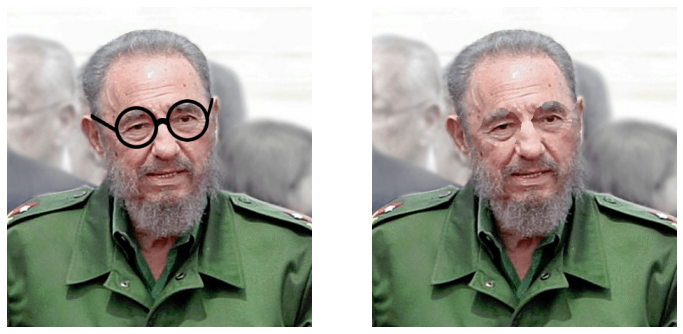

RMSE Original - Revolution(generated mask)
8.0243


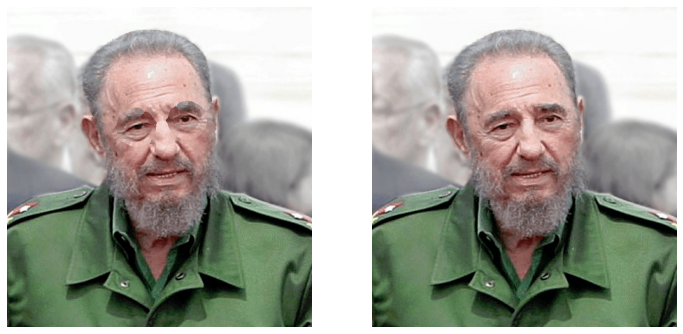

In [ ]:
img_revolution = inpainting_revolution(img, mask2)
plot_compare(img, img_revolution)
print('RMSE Original - Revolution(generated mask)')
RMSE(original_img, img_revolution)
plot_compare(img_revolution, original_img)

### Comparing Inpainting algorithms results

We can compare the results obtained by the three algoritms with the generated mask and rank them acordingly to it's `RMSE` results. A lower `RMSE` value means it's closer to the original Fidel's image, and we say it means a better inpainting.

| Rank | Algorithm | RMSE result |
|:--:|:--:|:--:|
|1| PyHeal (generated mask) | 7.5761 |
|2| Revolution (generated mask) | 8.0243 |
|3| Popular (generated mask) | 8.2365 |

# Comparing the results obtained with the different masks

Now we are going to rank all the obtained results ultil now, using the same criteria as before.

| Rank | Algorithm | RMSE result |
|:--:|:--:|:--:|
|1| PyHeal (generated mask) | 7.5761 |
|2| Revolution (generated mask) | 8.0243 |
|3| Popular (generated mask) | 8.2365 |
|4| PyHeal (manual mask) | 8.9814 |
|5| Revolution (manual mask) | 9.7663 |
|6| Popular (manual mask) | 9.8786 |

We can observe that all the results obtained by the generated mask worked better than the ones with the manual mask. Our algorithms with the generated mask show a better result even when compared with the PyHeal using the manual mask.

The PyHeal shows it robusteness in all cases, but we can notice that extracting a correct mask has important value on the final output. This shows that our algorithms might work better even than PyHeal in real life situations.

We made the manual mask using Photoshop to be abe to implement all the inpaiting algorithms. Then we noticed the following: the mask is crucial for any inpainting algorithm, so it's bad we have to count on image editors to extract such mask... it would be nice if we could inpaint any image with a single tool. So we came up with this mask extraction algorithm.

Bellow we can see the manual mask and the extracted mask side by side.



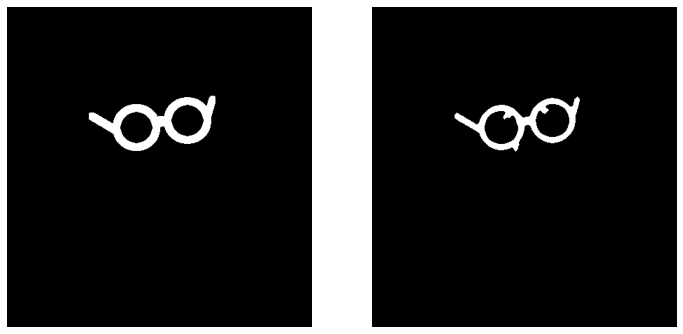

In [ ]:
plot_compare(mask, mask2)

# Applying our algorithms to a "real image"

After using Fidel's image as a reference for building and testing our algorithms we wanted to see if it would work in a non ideal scenario. We choose an Angela Davis portrait wearing eyeglasses in order to see if our algorithm would work on a real case scenario.

## Generating a mask for Angela Davis

We give a seed at her eyeglasses to start the algorithm.


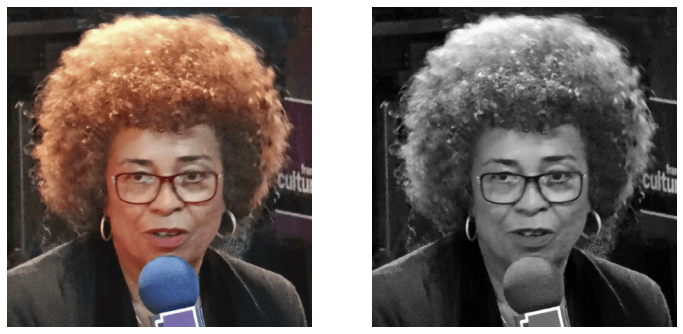

We'll need only values (not color) information to build the mask.


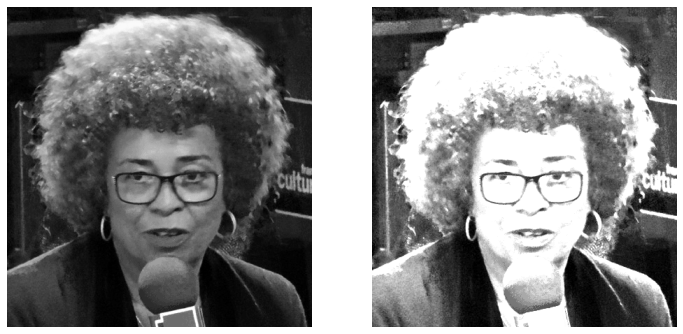

Brighter image


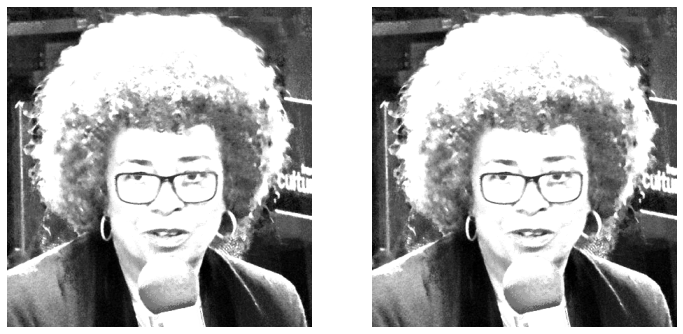

After the constrat modulation


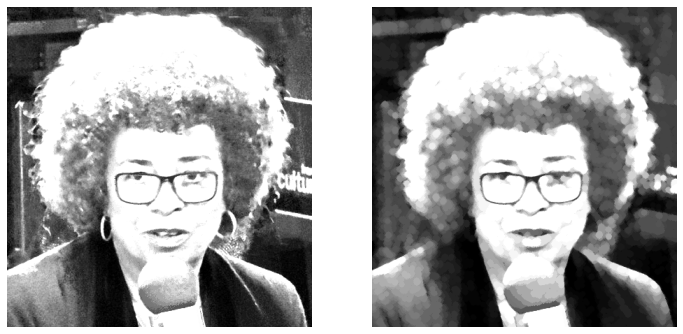

After performing an opening of radius 4


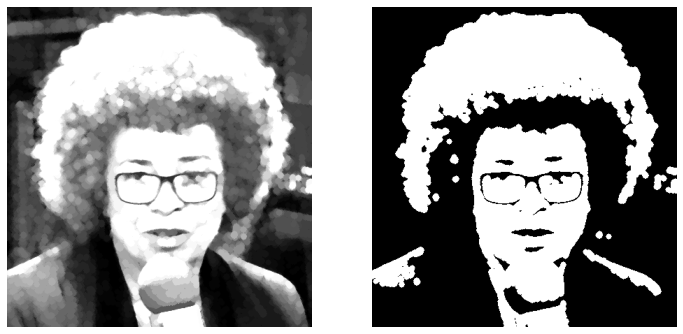

After binarization


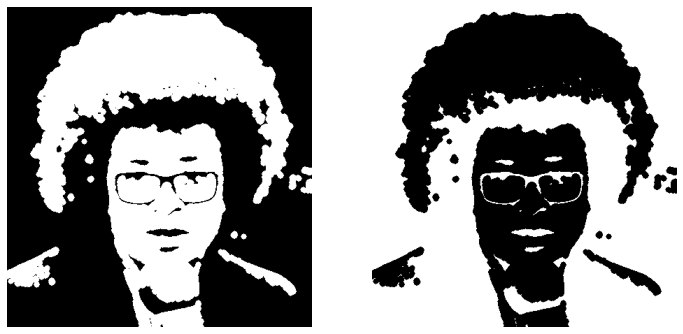

After inversion


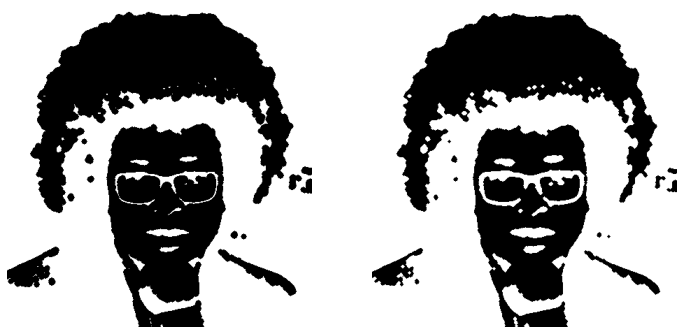

After dilation


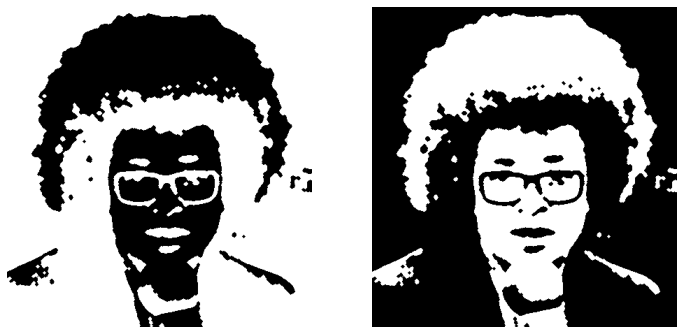

After re-inversion


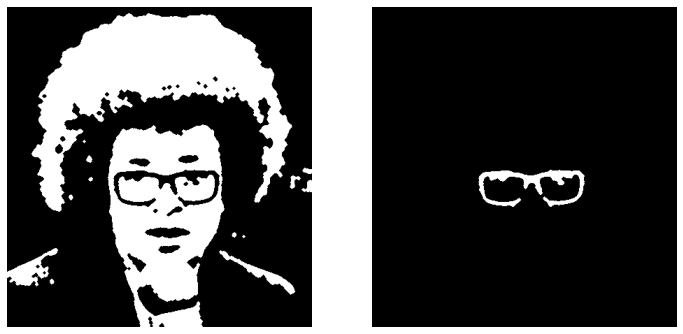

After region growing algorithm


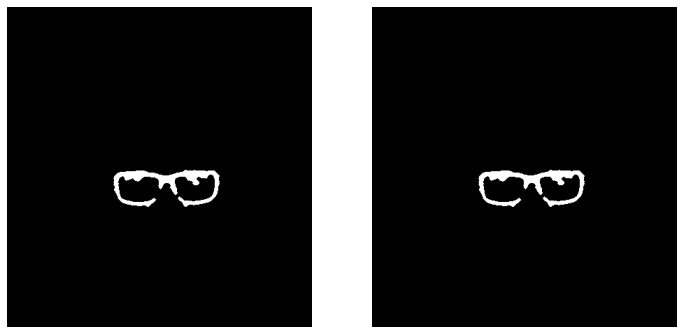

After normalization


In [ ]:
#generating the mask
img = imageio.imread('./images/original_Angela.png')
mask = mask_generator('./images/original_Angela.png', [240,200])

## Applying PyHeal Inpainting with the generated mask on Angela Davis

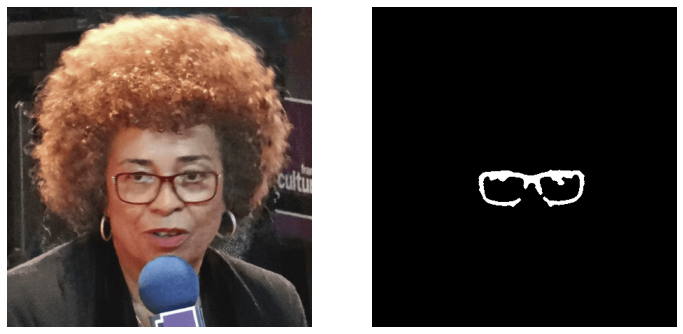

Angela Davis image and its generated eyeglasses mask


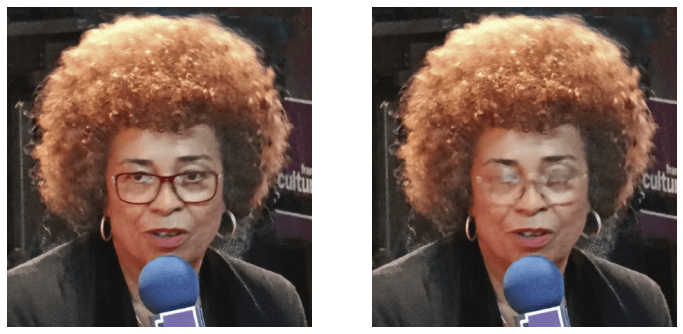

The PyHeal algorith result (right) compared with the original image (left)


In [ ]:
#comparing
plot_compare(img, mask)
print("Angela Davis image and its generated eyeglasses mask")

#inpainting using the generated mask
img_pyheal = inpanting_pyheal(img, mask, 4)
plot_compare(img, img_pyheal)
print("The PyHeal algorith result (right) compared with the original image (left)")

## Applying Popular Inpainting with the generated mask on Angela Davis

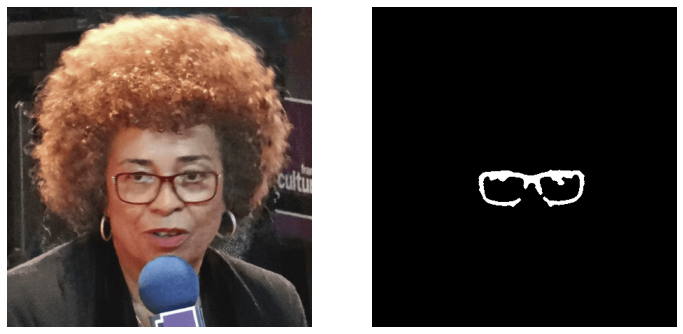

Angela Davis image and its generated eyeglasses mask


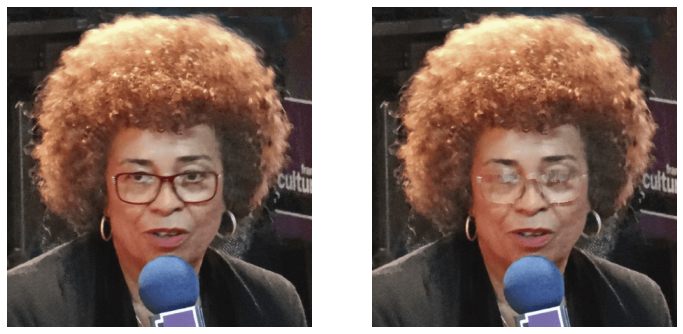

The Popular Inpainting algorith result (right) compared with the original image (left)


In [ ]:
#comparing
plot_compare(img, mask)
print("Angela Davis image and its generated eyeglasses mask")

#inpainting using the generated mask
img_popular = inpainting_popular(img, mask)
plot_compare(img, img_popular)
print("The Popular Inpainting algorith result (right) compared with the original image (left)")

## Applying Revolution Inpainting with the generated mask on Angela Davis

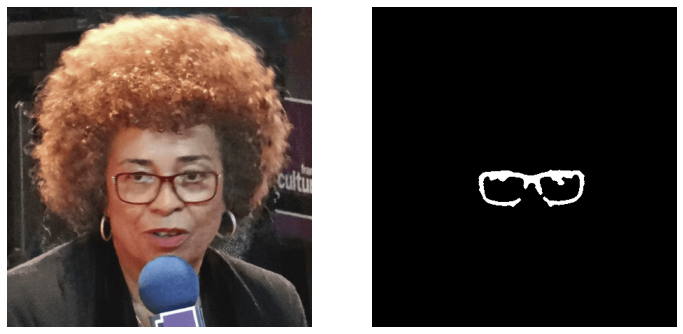

Angela Davis image and its generated eyeglasses mask


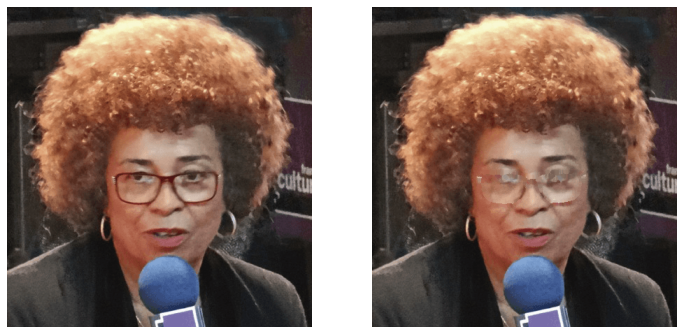

The Revolution Inpainting algorith result (right) compared with the original image (left)


In [ ]:
#comparing
plot_compare(img, mask)
print("Angela Davis image and its generated eyeglasses mask")

#inpainting using the generated mask
img_revolution = inpainting_revolution(img, mask)
plot_compare(img, img_revolution)
print("The Revolution Inpainting algorith result (right) compared with the original image (left)")